# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

# Imports

In [229]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# Config

In [230]:
# var 6
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

# Load data

In [231]:
df = pd.read_csv("original_data.txt", sep="\t", index_col="date", parse_dates=True, dtype=str)
df.drop(columns=["change", "open", "high", "low"], inplace=True)
df

,close,volume
date,,
2021-11-25,58156.6,57.89K
2021-11-24,57171.7,56.68K
2021-11-23,57573.2,72.48K
2021-11-22,56308.8,76.45K
2021-11-21,58714.3,40.98K
...,...,...
2010-07-22,0.1,2.16K
2010-07-21,0.1,0.58K
2010-07-20,0.1,0.26K


# Transform

In [232]:
df.index.dtype, df.dtypes

(dtype('<M8[ns]'),
 close     object
 volume    object
 dtype: object)

In [233]:
# cast close
df["close"] = df["close"].astype(np.float32)

# cast volume
_vol = np.ones((df.shape[0]), dtype=float)
for i, vol in enumerate(df["volume"]):
    coef = 1
    if vol == "-":
        vol = "0"
    elif "K" in vol:
        coef = 1000
        vol = vol.replace("K", "")
    elif "M" in vol:
        coef = 1000000
        vol = vol.replace("M", "")
    _vol[i] = float(vol) * coef

df["volume"] = _vol.astype(np.float32)
df

,close,volume
date,,
2021-11-25,"58,156.602","57,890.000"
2021-11-24,"57,171.699","56,680.000"
2021-11-23,"57,573.199","72,480.000"
2021-11-22,"56,308.801","76,450.000"
2021-11-21,"58,714.301","40,980.000"
...,...,...
2010-07-22,0.100,"2,160.000"
2010-07-21,0.100,580.000
2010-07-20,0.100,260.000


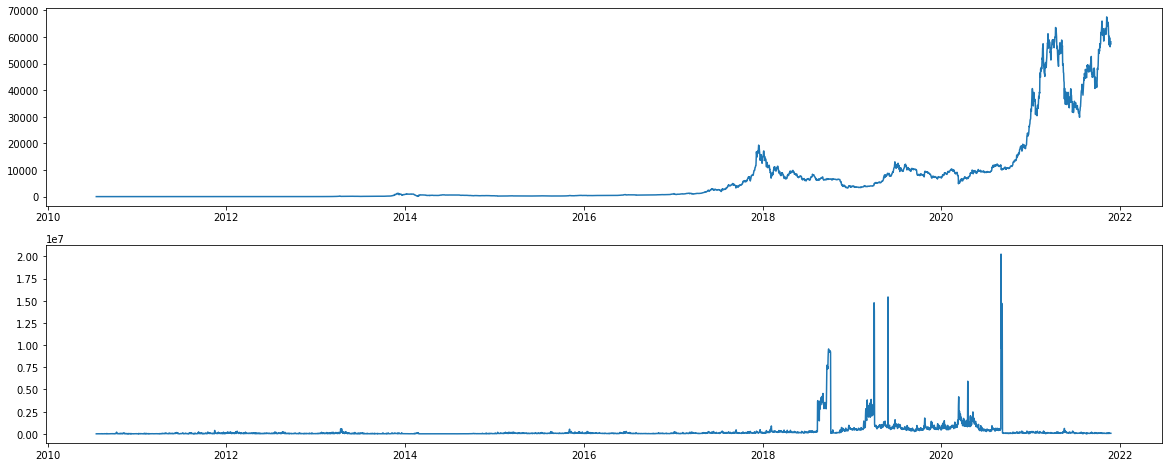

In [234]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(df.index, df["close"])
axes[1].plot(df.index, df["volume"])
plt.show()

# Save data

In [235]:
df.to_csv("prep_data.csv")

# Further work

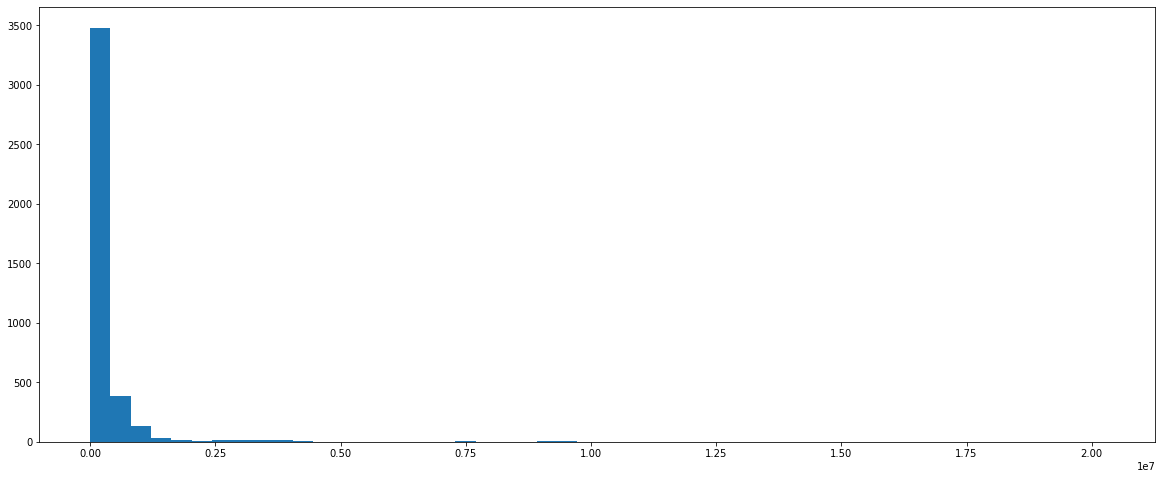

In [236]:
plt.hist(df["volume"], bins=50)
plt.show()

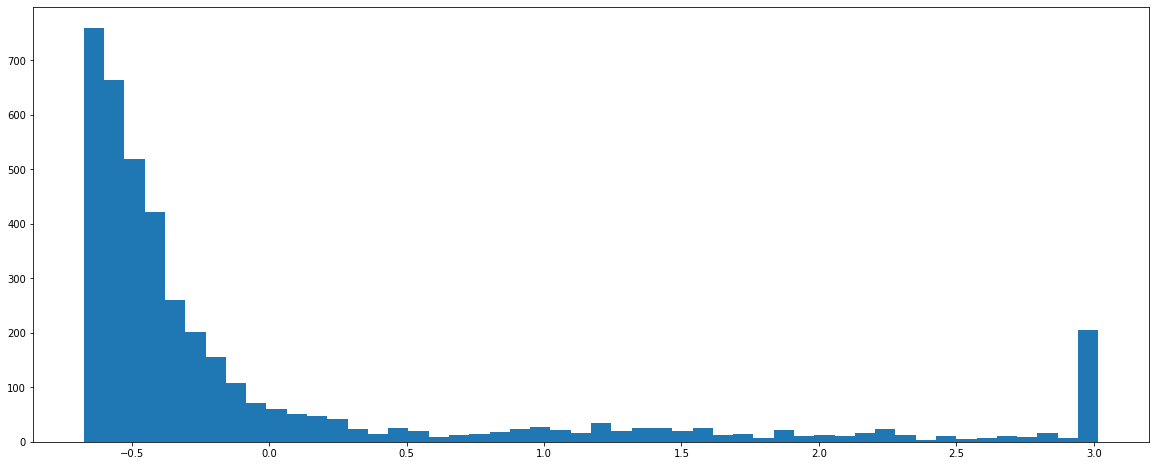

In [237]:
# clip volume and normalize
df["volume"] = np.clip(df["volume"], 0, 1000000)
df["volume_norm"] = (df["volume"] - df["volume"].mean())/df["volume"].std()

plt.hist(df["volume_norm"], bins=50)
plt.show()

# Fit a function to log of data, using lsm

In [238]:
def lsm(y):
    """
    LSM
    y = a * 10^(ln(X)) + b
    """
    # 1-d array to row vector
    Y = y.reshape(-1, 1)

    # creating F
    F = np.ones((len(y), 2))
    F[:, 1] = 10 ** np.log(np.arange(1, len(y) + 1))
    
    # normal
    FT = F.T
    FF = np.dot(FT, F)
    FFI = np.linalg.inv(FF)
    FFIFT = np.dot(FFI, FT)
    C = np.dot(FFIFT, Y)
    # returning array, reshaped from row vector to 1d
    return np.dot(F, C).reshape(-1)

In [239]:
df["log_close"] = np.log(df["close"].values)
df["log_fit"] = lsm(df["log_close"].values)

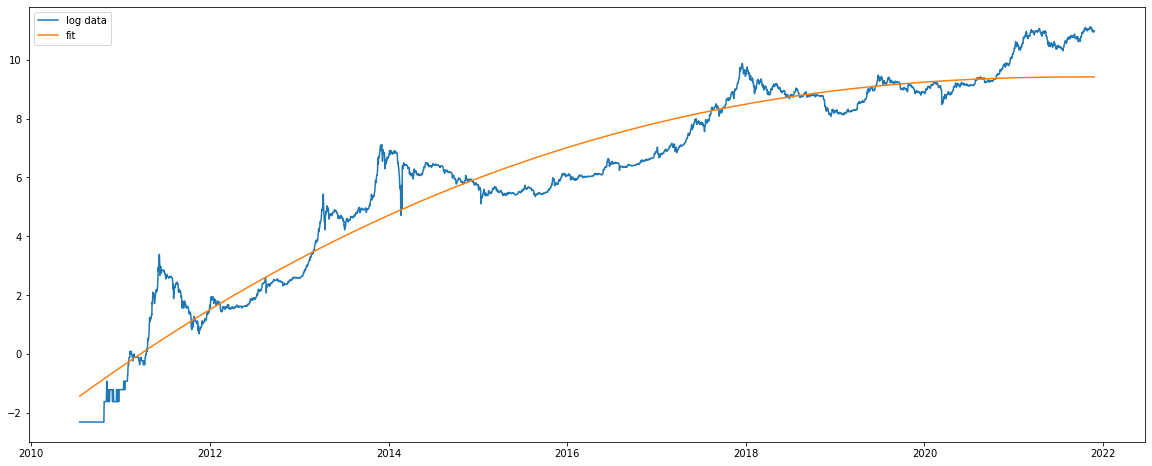

In [240]:
plt.plot(df.index, df["log_close"], label="log data")
plt.plot(df.index, df["log_fit"], label="fit")
plt.legend()
plt.show()

std 0.8915439232090009


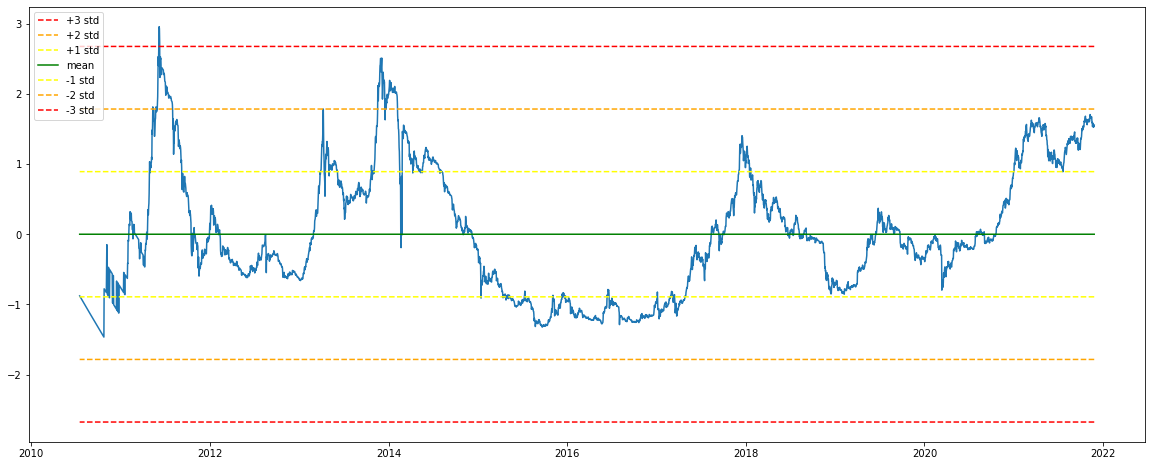

In [245]:
df["log_diff"] = df["log_close"] - df["log_fit"]

std = df["log_diff"].std()
print("std", std)

plt.plot(df.index, df["log_diff"])
plt.plot(df.index, np.ones((df.index.shape[0])) * std * 3, label="+3 std", color="red", linestyle="--")
plt.plot(df.index, np.ones((df.index.shape[0])) * std * 2, label="+2 std", color="orange", linestyle="--")
plt.plot(df.index, np.ones((df.index.shape[0])) * std * 1, label="+1 std", color="yellow", linestyle="--")
plt.plot(df.index, np.zeros((df.index.shape[0])), label="mean", color="green")
plt.plot(df.index, np.ones((df.index.shape[0])) * std * -1, label="-1 std", color="yellow", linestyle="--")
plt.plot(df.index, np.ones((df.index.shape[0])) * std * -2, label="-2 std", color="orange", linestyle="--")
plt.plot(df.index, np.ones((df.index.shape[0])) * std * -3, label="-3 std", color="red", linestyle="--")

plt.legend()
plt.show()